# Crossmatch one stamp classifier

You will need to install psycopg2 and astroquery.

This notebook gets all the objects xmatched as SNe or variable star

### Load libraries

*External dependencies*:

psycopg2: pip install psycopg2-binary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from astroquery.ned import Ned # pip install astroquery
import astropy.units as u
from astropy import coordinates

In [2]:
XMATCH_TABLE = [
    'OTHER',
    'CEPH',
    'DSCT',
    'EB',
    'LPV',
    'RRL',
    'SNE'
]

### Get credentials (not in github repository)

In [3]:
import json
credentials_file = "../alerceuser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [4]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
cur = conn.cursor()

### Show all the available tables

In [5]:
query = "select tablename from pg_tables where schemaname='public';"

cur.execute(query)
tables = cur.fetchall()

print(tables)

[('class',), ('asassn',), ('crtsnorth',), ('crtssouth',), ('detections',), ('objects',), ('insert_tmp',), ('tmp_oid',), ('probabilities',), ('xmatch',), ('features',), ('linear',), ('tns',), ('magref',), ('non_detections',), ('tmp',)]


### For each table, show column names and column types

In [6]:
dftab = pd.DataFrame()
for tab in tables:
    cols = pd.DataFrame()
    query = "select column_name from information_schema.columns where table_name = '%s';" % tab
    cur.execute(query)
    results = cur.fetchall()
    if len(results) > 0:
        cols["table"] = [tab[0] for i in results]
        cols["name"] = [res[0] for res in results]
        query = "select data_type from information_schema.columns where table_name = '%s';" % tab
        cur.execute(query)
        cols["dtype"] = [dt[0] for dt in cur.fetchall()]
        dftab = pd.concat([dftab, cols])
pd.options.display.max_rows = 999
display(dftab)
pd.options.display.max_rows = 101

,table,name,dtype
0,class,id,integer
1,class,name,character varying
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision


### Function to query data more easily

In [7]:
def sql_query(query):
    cur.execute(query)
    result = cur.fetchall()
    
    # Extract the column names
    col_names = []
    for elt in cur.description:
        col_names.append(elt[0])

    #Convert to dataframe
    df = pd.DataFrame(np.array(result), columns = col_names)
    return(df)

### Query objects with xmatch label

In [12]:
query='''
select oid, classxmatch, 
nobs, meanra, 
meandec

from objects

where objects.classxmatch is not null
'''
xmatched_sources = sql_query(query)

In [15]:
count = xmatched_sources.groupby('classxmatch').count()
for i in range(7):
    print(XMATCH_TABLE[i], count.iloc[i]['oid'])
print(xmatched_sources.tail())

OTHER 2388
CEPH 780
DSCT 1018
EB 44787
LPV 4475
RRL 20589
SNE 1000
                oid classxmatch nobs            meanra           meandec
75032  ZTF17aaazqqa           3    1        15.5786863        38.0385364
75033  ZTF18aabeppx           5    3  253.039347333333        35.1768932
75034  ZTF18aakzliv           6    7  260.479410457143  29.3093011857143
75035  ZTF18aaxjigo           3  125    308.9459258216     40.8836436768
75036  ZTF18abbuwlf           4  122  2.07410858114754  52.7658553262295


## Get oids for SNe and Variable stars

In [33]:
SNe = xmatched_sources[xmatched_sources.classxmatch == '6']
VS = xmatched_sources[(xmatched_sources.classxmatch == '1') 
                      | (xmatched_sources.classxmatch == '2')
                      | (xmatched_sources.classxmatch == '3')
                      | (xmatched_sources.classxmatch == '4')
                      | (xmatched_sources.classxmatch == '5')]
print('We have %d SNe and %d variable stars' % (len(SNe), len(VS)))
print(SNe.head())

We have 1000 SNe and 71649 variable stars
              oid classxmatch nobs            meanra           meandec
85   ZTF18abcyilc           6    7  184.048474757143  68.5583956571429
127  ZTF18aayiahw           6    9  209.808347511111  28.5407553888889
135  ZTF18acvwagt           6    2      179.98748235       -0.55052565
143  ZTF18abdiqdh           6    9  184.683486444444  44.7819575666667
217  ZTF18aahheaj           6    5      195.11048026       18.61935766


### Visualize object

In [36]:
def get_lc_data(oid, doplot = False, doNED = False):
    # detections
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    detections = sql_query(query)
    for col in list(detections):
        if col != 'oid':
            detections[col] = pd.to_numeric(detections[col], errors = 'ignore')
        
    # non detections
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    non_detections = sql_query(query)
    for col in list(non_detections):
        if col != 'oid':
            non_detections[col] = pd.to_numeric(non_detections[col], errors = 'ignore')
    
    # sort by date
    detections.sort_values(by='mjd', inplace=True)
    non_detections.sort_values(by='mjd', inplace=True)
    
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=xmatched_sources.meanra[xmatched_sources.oid == oid], 
                                  dec=xmatched_sources.meandec[xmatched_sources.oid == oid], 
                                  unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
    
    # plot
    if doplot:
        classxmatch = xmatched_sources['classxmatch'][xmatched_sources.oid == oid].values[0]
        classxmatch = XMATCH_TABLE[int(classxmatch)]
        fig, ax = plt.subplots(figsize = (14, 7))
        labels = {1: 'g', 2: 'r'}
        colors = {1: 'g', 2: 'r'}
        for fid in [1, 2]:
            mask = detections.fid == fid
            ax.errorbar(detections[mask].mjd, detections[mask].magpsf_corr, 
                yerr = detections[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
            mask = (non_detections.fid == fid) & (non_detections.diffmaglim > -900)
            ax.scatter(non_detections[mask].mjd, non_detections[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                        marker = 'v', label = "lim.mag. %s" % labels[fid])
        ax.set_title('oid: %s, xmatch class: %s' % (oid, classxmatch))
        ax.set_xlabel("MJD")
        ax.set_ylabel("Magnitude")
        ax.legend()
        ax.set_ylim(ax.get_ylim()[::-1])        
        
    # return data
    return detections, non_detections

## Draw random object

ZTF19aacwljg


No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,SDSS J093328.32+192721.3,143.36801,19.45592,G,--,--,,20.1g,0.567,0,0,15,1,0,4,0
2,SDSS J093328.65+192722.3,143.36938,19.45622,G,--,--,,22.5g,0.577,0,0,15,1,0,4,0
3,SDSS J093329.46+192647.8,143.37276,19.44662,G,--,--,,20.8g,0.174,0,0,15,1,0,4,0
4,SDSS J093329.55+192620.5,143.37316,19.43905,G,--,--,,22.6g,0.494,0,0,15,1,0,4,0
5,SDSS J093330.52+192703.6,143.3772,19.45102,G,--,--,,22.9g,0.501,0,0,15,1,0,3,0


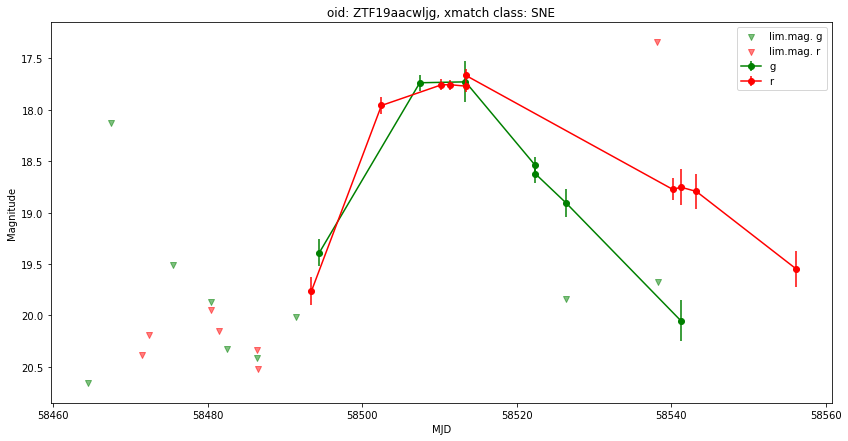

In [50]:
random_oid = SNe['oid'].iloc[np.random.randint(len(SNe))]
print(random_oid)
detections, non_detections = get_lc_data(random_oid, doplot=True, doNED=True);

ZTF18aabjrfi


No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,SDSS J084747.17+420200.5,131.94655,42.03348,G,--,--,,23.6g,0.434,0,0,15,1,0,3,0
2,SDSS J084747.71+420150.4,131.94882,42.03068,G,--,--,,21.5g,0.261,0,0,15,1,0,4,0
3,SDSS J084749.13+420149.9,131.95472,42.03055,G,--,--,,23.0g,0.093,0,0,15,1,0,4,0
4,SDSS J084750.96+420120.4,131.96236,42.02235,G,--,--,,22.2g,0.54,0,0,15,1,0,4,0


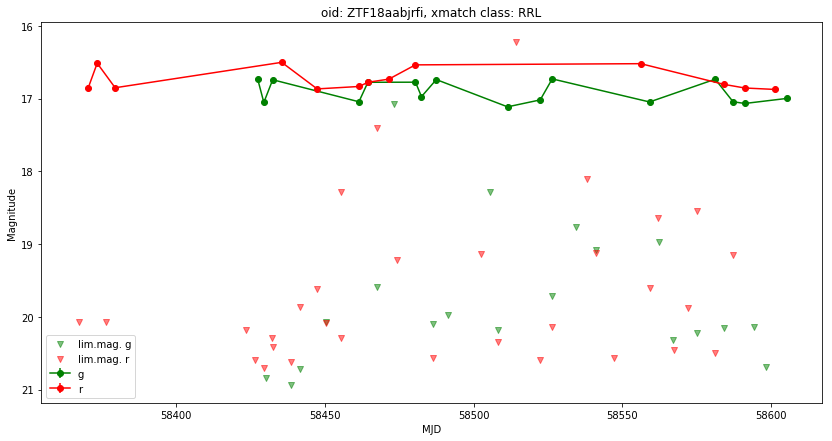

In [47]:
random_oid = VS['oid'].iloc[np.random.randint(len(VS))]
print(random_oid)
detections, non_detections = get_lc_data(random_oid, doplot=True, doNED=True);

## Save dataframes

In [48]:
SNe[['oid', 'classxmatch', 'nobs']].to_pickle('SNe_xmatch.pkl')
VS[['oid', 'classxmatch', 'nobs']].to_pickle('VS_xmatch.pkl')